In [3]:
import PyKDL
import kdl_parser_py.urdf
import pickle
import torch
import sys
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

In [4]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/act_demo_real_z1_push_sb/ckpt_chunk_size_100/"

config_path = ckpt_path + "config.pkl"
policy_model_path = ckpt_path + "policy_best.ckpt"
stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = ACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]
BASE_DELAY = 13

print("loading ACT policy success")

{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 6, 'no_encoder': False}
DETR Args:  Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=[], enc_layers=4, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=400, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='ACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=None, chunk_size=None, temporal_agg=False, use_vq=False, vq=False, vq_class=None, vq_dim=None, load_pretrain=False, action_dim=None, eval_every=500, validate_every=500, save_eve

In [5]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

In [62]:
# h5data_file = "/mnt/data1/act/act_demo_real_z1_push_sb/2024-03-08_06-14-51/episode_1.hdf5"
h5data_file = "/mnt/data1/act/act_demo_real_z1_push_sb/episode_30.hdf5"

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        index = 0
        qpos_np = root["/observations/qpos"][index]
        img_np = root["/observations/images/wrist"][index]
        print("img_np: ",img_np.shape)

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_img = pre_proccess_img(img_np)
        # print("qpos: ",qpos.shape)
        print("curr_img: ",curr_img.shape)
        all_actions = policy(qpos, curr_img)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)



img_np:  (480, 640, 3)
curr_img:  torch.Size([1, 1, 3, 480, 640])
all_actions:  (100, 6)
action_obs_np:  (860, 6)


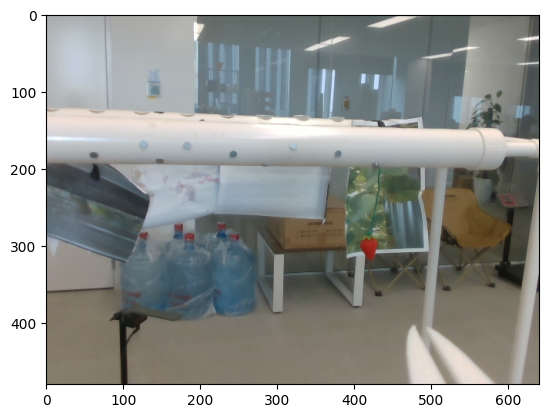

In [63]:
plt.imshow(cv.cvtColor(img_np, cv.COLOR_BGR2RGB))

In [64]:
joint_states_traj = []
actual_actions = []
for i, raw_action in enumerate(all_actions):
    actual_action = post_process_action(raw_action)
    actual_actions.append(actual_action)
actual_actions = np.asarray(actual_actions)

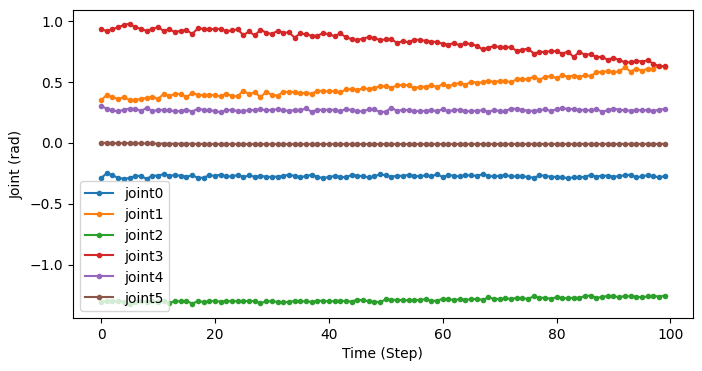

In [65]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')
plt.plot(actual_actions[:, 5], marker=".", label='joint5')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


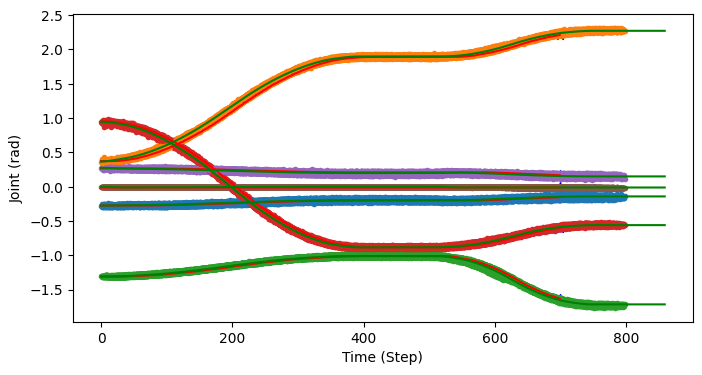

In [66]:
plt.figure(figsize=(8, 4))
qpos_gts = []
all_actual_actions = []
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        for index in range(700):
            start_step = index 
            qpos_np = root["/observations/qpos"][index]
            qpos_gts.append(qpos_np.copy())
            img_np = root["/observations/images/wrist"][index]
            qpos = pre_process_qpos(qpos_np)
            curr_img = pre_proccess_img(img_np)
            # print("qpos: ",qpos.shape)
            # print("curr_img: ",curr_img.shape)
            all_actions = policy(qpos, curr_img)
            all_actions = all_actions.squeeze(0).cpu().numpy()
            joint_states_traj = []
            actual_actions = []
            steps = np.arange(0, len(all_actions), 1)
            steps = steps + start_step
            for i, raw_action in enumerate(all_actions):
                actual_action = post_process_action(raw_action)
                actual_actions.append(actual_action)
            actual_actions = np.asarray(actual_actions)
            all_actual_actions.append(actual_actions)
            plt.plot(steps, actual_actions[:, 0], marker=".", c="C0", label='joint0')
            plt.plot(steps, actual_actions[:, 1], marker=".", c="C1", label='joint1')
            plt.plot(steps, actual_actions[:, 2], marker=".", c="C2", label='joint2')
            plt.plot(steps, actual_actions[:, 3], marker=".", c="C3", label='joint3')
            plt.plot(steps, actual_actions[:, 4], marker=".", c="C4", label='joint4')
            plt.plot(steps, actual_actions[:, 5], marker=".", c="C5", label='joint5')
qpos_gts = np.asarray(qpos_gts)
plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.scatter(len(qpos_gts), qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(len(qpos_gts), qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(len(qpos_gts), qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(len(qpos_gts), qpos_np[3], marker="*", c="b", s=50, label='joint3')
plt.scatter(len(qpos_gts), qpos_np[4], marker="*", c="b", s=50, label='joint4')
plt.scatter(len(qpos_gts), qpos_np[5], marker="*", c="b", s=50, label='joint5')
plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')


plt.plot(action_obs_np[:, 0], c="g",label='joint0')
plt.plot(action_obs_np[:, 1], c="g",label='joint1')
plt.plot(action_obs_np[:, 2], c="g",label='joint2')
plt.plot(action_obs_np[:, 3], c="g",label='joint3')
plt.plot(action_obs_np[:, 4], c="g",label='joint4')
plt.plot(action_obs_np[:, 5], c="g",label='joint5')




In [67]:
qpos_np

array([-0.15424179,  2.209791  , -1.634132  , -0.60226464,  0.16515073,
       -0.01230135], dtype=float32)

## KDL Forward Kinematics

In [23]:
actual_actions.shape

(100, 6)

In [24]:
def joint_states_to_jnt_array(joint_states):
    # Convert joint states to a KDL JntArray
    kdl_joint_array = PyKDL.JntArray(len(joint_states))
    for i, value in enumerate(joint_states):
        kdl_joint_array[i] = value
    kdl_joint_array
    return kdl_joint_array

def get_frame_pose(fk_solver, kdl_joint_array):
    frame = PyKDL.Frame()
    fk_solver.JntToCart(kdl_joint_array, frame)
    # Extract position and orientation
    position = [frame.p.x(), frame.p.y(), frame.p.z()]
    orientation = [frame.M.GetQuaternion()[0], frame.M.GetQuaternion()[1],
                    frame.M.GetQuaternion()[2], frame.M.GetQuaternion()[3]]
    return position, orientation

def joint_states_to_ee_pose(all_joint_states, fk_solver):
    positions = []
    orientations = []
    for i, joint_states in enumerate(all_joint_states):
        kdl_joint_array = joint_states_to_jnt_array(joint_states)
        position, orientation = get_frame_pose(fk_solver, kdl_joint_array)
        positions.append(position)
        orientations.append(orientation)
        
    positions = np.asarray(positions)
    orientations = np.asarray(orientations)
    return positions, orientations

def plot_3d_trajectory(traj, figsize=(8, 6), title="EE Trajectory"):
    """
    Plots a 3D trajectory with enhanced visualization.

    Args:
        traj (list of lists): The 3D trajectory data, where each inner list represents a point (x, y, z).
        figsize (tuple, optional): Figure size in inches. Defaults to (8, 6).
        title (str, optional): Plot title. Defaults to "3D Trajectory".
    """

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory with clear markers and line
    ax.plot(*zip(*traj), color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)

    # Set labels, title, and initial viewpoint
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # ax.set_xlim(-1, +1)
    # ax.set_ylim(0, 1)
    # ax.set_zlim(0, 0.5)
    ax.set_title(title)
    ax.view_init(elev=20, azim=-60)  # Adjust viewpoint as needed

    # Optional: Add grid and axes limits
    ax.grid(True)
    # Set appropriate limits based on your data range

    plt.show()




In [25]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../z1_robot.xacro")
print("ok: ", ok)
chain = tree.getChain("link00", "link06")  # Replace with actual link names
fk_solver = PyKDL.ChainFkSolverPos_recursive(chain)


ok:  True


In [26]:
all_gt_ee_pose, orientations = joint_states_to_ee_pose(action_obs_np, fk_solver)


In [28]:
all_positions = []
all_orientations = []
for i in range(1):
    actual_actions = all_actual_actions[i]
    positions, orientations = joint_states_to_ee_pose(actual_actions, fk_solver)
    all_positions.append(positions)
    all_orientations.append(orientations)

In [29]:
len(all_gt_ee_pose)

820

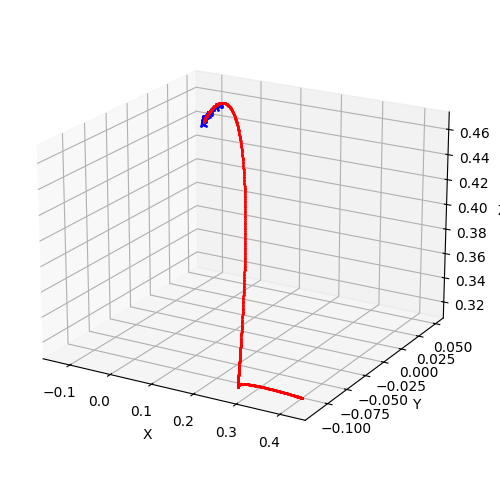

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

plot_len = 700
# Plot the trajectory with clear markers and line
for traj in all_positions[:plot_len]:
    ax.plot(*zip(*traj), color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)

ax.plot(*zip(*all_gt_ee_pose[:plot_len]), color='red', marker='o', linestyle='-', linewidth=1, markersize=1)

# Set labels, title, and initial viewpoint
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1, +1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 0.5)
ax.view_init(elev=20, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

In [31]:
all_gt_ee_pose[-1]

array([ 0.41860396, -0.10963946,  0.31219053])

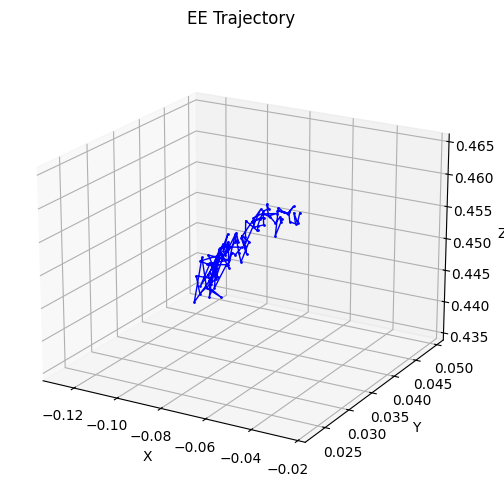

In [32]:
plot_3d_trajectory(positions)

ok:  True


In [44]:
joint_states = [-0.0010887124809900177, 1.4884100482973608, -1.3307996878993358, -0.216861553564872, 0.0002238291478332484, 1.4884889882406714e-05]

In [46]:
kdl_joint_array = joint_states_to_jnt_array(joint_states)

In [47]:
frame = PyKDL.Frame()
fk_solver.JntToCart(kdl_joint_array, frame)
# Extract position and orientation
position = [frame.p.x(), frame.p.y(), frame.p.z()]
orientation = [frame.M.GetQuaternion()[0], frame.M.GetQuaternion()[1],
                frame.M.GetQuaternion()[2], frame.M.GetQuaternion()[3]]

In [48]:
print(position)

[0.31443262989082954, -0.0003313144633375164, 0.48144798208486855]
